In [1]:
import pandas as pd
import pickle
from nltk import FreqDist
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.keyedvectors import KeyedVectors

from tensorflow.keras.layers import Flatten,Embedding,Dense
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras


# machine learning
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
poptypes_df = pd.read_csv("../data/poptypes_df.csv")
poptypes = poptypes_df["poptype"].tolist()
poptypes

['right-wing',
 'left-wing',
 'nationalist',
 'authoritatian',
 'exclusionary',
 'radical',
 'nativist',
 'inclusionary',
 'neoliberal',
 'moderate']

In [3]:
with open("../data/concs_labeled_min.pickle", "rb") as f:
    concs_labeled = pickle.load(f)

In [4]:
concs_labeled[:10]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn',
   'key',
   'electoral',
   'success'],
  'right-wing',
  '2011',
  'Bos et al

In [5]:
len(concs_labeled)

7915

In [6]:
pd.DataFrame(concs_labeled[:10])

,0,1,2,3
0,"[access, use, find, print, homepage, cite, art...",right-wing,2011,Bos et al. 2011
1,"[access, use, find, print, homepage, cite, art...",right-wing,2011,Bos et al. 2011
2,"[view, view, relate, article, cite, article, v...",right-wing,2011,Bos et al. 2011
3,"[article, cite, article, view, cite, article, ...",right-wing,2011,Bos et al. 2011
4,"[success, study, test, assumption, compare, ef...",right-wing,2011,Bos et al. 2011
5,"[medium, coverage, public, image, political, l...",right-wing,2011,Bos et al. 2011
6,"[party, leader, leader, party, strength, mediu...",right-wing,2011,Bos et al. 2011
7,"[dependent, medium, leader, party, ﬁnding, dis...",right-wing,2011,Bos et al. 2011
8,"[party, ﬁnding, discuss, light, extant, resear...",right-wing,2011,Bos et al. 2011
9,"[ﬁnding, discuss, light, extant, research, par...",right-wing,2011,Bos et al. 2011


In [7]:
y = [el[1] for el in concs_labeled]

In [8]:
labels_counts = dict([(poptype, y.count(poptype)) for poptype in poptypes])
labels_counts

{'right-wing': 2736,
 'left-wing': 765,
 'nationalist': 1907,
 'authoritatian': 647,
 'exclusionary': 373,
 'radical': 588,
 'nativist': 189,
 'inclusionary': 208,
 'neoliberal': 253,
 'moderate': 249}

In [9]:
classes = poptypes

# Features preprocessing

In [10]:
concs = [el[0] for el in concs_labeled]
labels = [el[1] for el in concs_labeled]
years = [el[2] for el in concs_labeled]

In [11]:
vocab_counts = FreqDist([w for conc in concs for w in conc]).most_common()
vocab_counts[:50]

[('party', 3868),
 ('political', 1828),
 ('people', 1222),
 ('democracy', 882),
 ('politic', 833),
 ('leader', 754),
 ('case', 703),
 ('support', 699),
 ('discourse', 613),
 ('attitude', 591),
 ('economic', 575),
 ('elite', 570),
 ('effect', 564),
 ('study', 556),
 ('country', 541),
 ('government', 537),
 ('movement', 499),
 ('article', 487),
 ('ideology', 485),
 ('power', 479),
 ('policy', 476),
 ('democratic', 474),
 ('different', 457),
 ('analysis', 450),
 ('voter', 444),
 ('new', 443),
 ('argue', 442),
 ('election', 434),
 ('european', 410),
 ('level', 401),
 ('social', 398),
 ('issue', 389),
 ('focus', 386),
 ('rise', 378),
 ('form', 366),
 ('electoral', 364),
 ('vote', 348),
 ('rhetoric', 346),
 ('liberal', 344),
 ('mainstream', 343),
 ('state', 338),
 ('use', 329),
 ('medium', 329),
 ('term', 319),
 ('result', 317),
 ('appeal', 316),
 ('position', 316),
 ('strategy', 308),
 ('include', 301),
 ('claim', 296)]

In [12]:
len(vocab_counts)

9724

In [13]:
#N = 10000
vocab = [tup[0] for tup in vocab_counts] #[:N]

In [14]:
vectorizer = TfidfVectorizer(token_pattern=r"\w+\/?|\_\w+", vocabulary=vocab, lowercase=False)
X = vectorizer.fit_transform([" ".join(conc) for conc in concs]).A

In [15]:
type(X)

numpy.ndarray

In [16]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.082141,0.0,0.0,0.0,0.000000,0.138999,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.091092,0.0,0.0,0.0,0.000000,0.154145,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.080752,0.0,0.0,0.0,0.000000,0.273299,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7910,0.102767,0.0,0.0,0.0,0.164701,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7911,0.000000,0.0,0.0,0.0,0.137193,0.144858,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.376717
7912,0.000000,0.0,0.0,0.0,0.265843,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7913,0.084102,0.0,0.0,0.0,0.269574,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
len(y)

7915

In [18]:
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(X, y, years, test_size=0.2, random_state=1)

# Model development

## Logistic regression

In [19]:
LR = LogisticRegression(penalty="l2", C=100, max_iter=1000, n_jobs=8)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6146557169930512

In [36]:
y_predicted = LR.predict(X_test)
y_predicted[:10]

array(['right-wing', 'left-wing', 'authoritatian', 'authoritatian',
       'nationalist', 'nationalist', 'right-wing', 'right-wing',
       'right-wing', 'authoritatian'], dtype='<U13')

In [37]:
y_test[:10]

['authoritatian',
 'nationalist',
 'authoritatian',
 'authoritatian',
 'nationalist',
 'nationalist',
 'right-wing',
 'right-wing',
 'right-wing',
 'authoritatian']

In [38]:
f1_score(y_predicted, y_test, average="weighted")

0.6255912662791981

## Multinomial Naive Bayes

In [32]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
MNB.score(X_test, y_test)

0.41010498687664043

## Random Forests

In [33]:
RF = RandomForestClassifier(n_jobs=-1, n_estimators=100)
RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.568241469816273

## Extremely Randomized Trees

In [34]:
# apply carefully! takes time
ET = ExtraTreesClassifier(n_jobs=-1, n_estimators=100)
ET.fit(X_train, y_train)
ET.score(X_test, y_test)

0.6148293963254593

# Continuing with Logistic Regression

In [19]:
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(X, y, years, test_size=0.2, random_state=0)

In [20]:
LR = LogisticRegression(penalty="l2", C=100, max_iter=1000, n_jobs=8, random_state=0)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6190777005685407

In [21]:
classifier = LR

In [22]:
classifier.score(X_test, y_test)

0.6190777005685407

In [71]:
np.round(accuracy_score(y_test, y_predicted), 2)

0.62

In [74]:
y_test

['neoliberal',
 'nationalist',
 'neoliberal',
 'nationalist',
 'right-wing',
 'authoritatian',
 'moderate',
 'right-wing',
 'right-wing',
 'radical',
 'right-wing',
 'right-wing',
 'nationalist',
 'authoritatian',
 'right-wing',
 'radical',
 'radical',
 'nationalist',
 'right-wing',
 'exclusionary',
 'nativist',
 'nationalist',
 'nationalist',
 'right-wing',
 'neoliberal',
 'exclusionary',
 'nationalist',
 'left-wing',
 'nationalist',
 'left-wing',
 'right-wing',
 'left-wing',
 'nationalist',
 'nationalist',
 'right-wing',
 'nationalist',
 'right-wing',
 'nationalist',
 'authoritatian',
 'nationalist',
 'right-wing',
 'right-wing',
 'right-wing',
 'left-wing',
 'right-wing',
 'left-wing',
 'right-wing',
 'right-wing',
 'nationalist',
 'exclusionary',
 'radical',
 'authoritatian',
 'right-wing',
 'right-wing',
 'authoritatian',
 'right-wing',
 'nativist',
 'right-wing',
 'nationalist',
 'nationalist',
 'neoliberal',
 'right-wing',
 'exclusionary',
 'left-wing',
 'right-wing',
 'national

In [76]:
np.round(accuracy_score(y_test, ["right-wing"] * len(y_predicted)), 2)

0.36

In [23]:
y_predicted = classifier.predict(X_test)
f1_score(y_predicted, y_test, average="weighted")

0.6312233581402467

In [24]:
len(years_test)

1583

In [25]:
test_classes_reality = dict([(poptype, list(y_test).count(poptype)) for poptype in poptypes])
test_classes_reality

{'right-wing': 563,
 'left-wing': 154,
 'nationalist': 362,
 'authoritatian': 138,
 'exclusionary': 84,
 'radical': 113,
 'nativist': 34,
 'inclusionary': 41,
 'neoliberal': 48,
 'moderate': 46}

In [26]:
labels = poptypes
labels

['right-wing',
 'left-wing',
 'nationalist',
 'authoritatian',
 'exclusionary',
 'radical',
 'nativist',
 'inclusionary',
 'neoliberal',
 'moderate']

In [27]:
labels_reality = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_reality.items()]
labels_reality

['right-wing (N=563)',
 'left-wing (N=154)',
 'nationalist (N=362)',
 'authoritatian (N=138)',
 'exclusionary (N=84)',
 'radical (N=113)',
 'nativist (N=34)',
 'inclusionary (N=41)',
 'neoliberal (N=48)',
 'moderate (N=46)']

In [28]:
test_classes_prediction =  dict([(poptype, list(y_predicted).count(poptype)) for poptype in poptypes])
test_classes_prediction

{'right-wing': 666,
 'left-wing': 125,
 'nationalist': 433,
 'authoritatian': 129,
 'exclusionary': 50,
 'radical': 92,
 'nativist': 17,
 'inclusionary': 19,
 'neoliberal': 23,
 'moderate': 29}

In [29]:
labels_prediction = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_prediction.items()]
labels_prediction

['right-wing (N=666)',
 'left-wing (N=125)',
 'nationalist (N=433)',
 'authoritatian (N=129)',
 'exclusionary (N=50)',
 'radical (N=92)',
 'nativist (N=17)',
 'inclusionary (N=19)',
 'neoliberal (N=23)',
 'moderate (N=29)']

In [30]:
pd.DataFrame([test_classes_reality, test_classes_prediction], index=["reality", "prediction"]).T

,reality,prediction
right-wing,563,666
left-wing,154,125
nationalist,362,433
authoritatian,138,129
exclusionary,84,50
radical,113,92
nativist,34,17
inclusionary,41,19
neoliberal,48,23
moderate,46,29


In [33]:
matrix = confusion_matrix(y_test, y_predicted, labels=labels) #, normalize="true")
dataframe = pd.DataFrame(matrix, index=labels_reality, columns=labels_prediction)
dataframe

,right-wing (N=666),left-wing (N=125),nationalist (N=433),authoritatian (N=129),exclusionary (N=50),radical (N=92),nativist (N=17),inclusionary (N=19),neoliberal (N=23),moderate (N=29)
right-wing (N=563),441,28,54,12,7,10,0,3,4,4
left-wing (N=154),47,59,25,6,2,12,0,0,1,2
nationalist (N=362),63,10,255,13,5,5,5,1,3,2
authoritatian (N=138),23,4,20,84,2,4,0,1,0,0
exclusionary (N=84),23,3,24,3,30,1,0,0,0,0
radical (N=113),31,8,15,5,3,50,0,1,0,0
nativist (N=34),8,1,12,0,0,1,12,0,0,0
inclusionary (N=41),10,4,7,1,1,5,0,13,0,0
neoliberal (N=48),10,4,15,3,0,1,0,0,15,0
moderate (N=46),10,4,6,2,0,3,0,0,0,21


In [34]:
totals = []
for i in range(len(dataframe)):
    totals.append(dataframe.iloc[i].sum())
freqs_dict = {}
for col in dataframe.columns:
    freqs_dict[col] = dataframe[col] / totals
freqs_df = pd.DataFrame(freqs_dict)
freqs_df

,right-wing (N=666),left-wing (N=125),nationalist (N=433),authoritatian (N=129),exclusionary (N=50),radical (N=92),nativist (N=17),inclusionary (N=19),neoliberal (N=23),moderate (N=29)
right-wing (N=563),0.783304,0.049734,0.095915,0.021314,0.012433,0.017762,0.000000,0.005329,0.007105,0.007105
left-wing (N=154),0.305195,0.383117,0.162338,0.038961,0.012987,0.077922,0.000000,0.000000,0.006494,0.012987
nationalist (N=362),0.174033,0.027624,0.704420,0.035912,0.013812,0.013812,0.013812,0.002762,0.008287,0.005525
authoritatian (N=138),0.166667,0.028986,0.144928,0.608696,0.014493,0.028986,0.000000,0.007246,0.000000,0.000000
exclusionary (N=84),0.273810,0.035714,0.285714,0.035714,0.357143,0.011905,0.000000,0.000000,0.000000,0.000000
radical (N=113),0.274336,0.070796,0.132743,0.044248,0.026549,0.442478,0.000000,0.008850,0.000000,0.000000
nativist (N=34),0.235294,0.029412,0.352941,0.000000,0.000000,0.029412,0.352941,0.000000,0.000000,0.000000
inclusionary (N=41),0.243902,0.097561,0.170732,0.024390,0.024390,0.121951,0.000000,0.317073,0.000000,0.000000
neoliberal (N=48),0.208333,0.083333,0.312500,0.062500,0.000000,0.020833,0.000000,0.000000,0.312500,0.000000
moderate (N=46),0.217391,0.086957,0.130435,0.043478,0.000000,0.065217,0.000000,0.000000,0.000000,0.456522


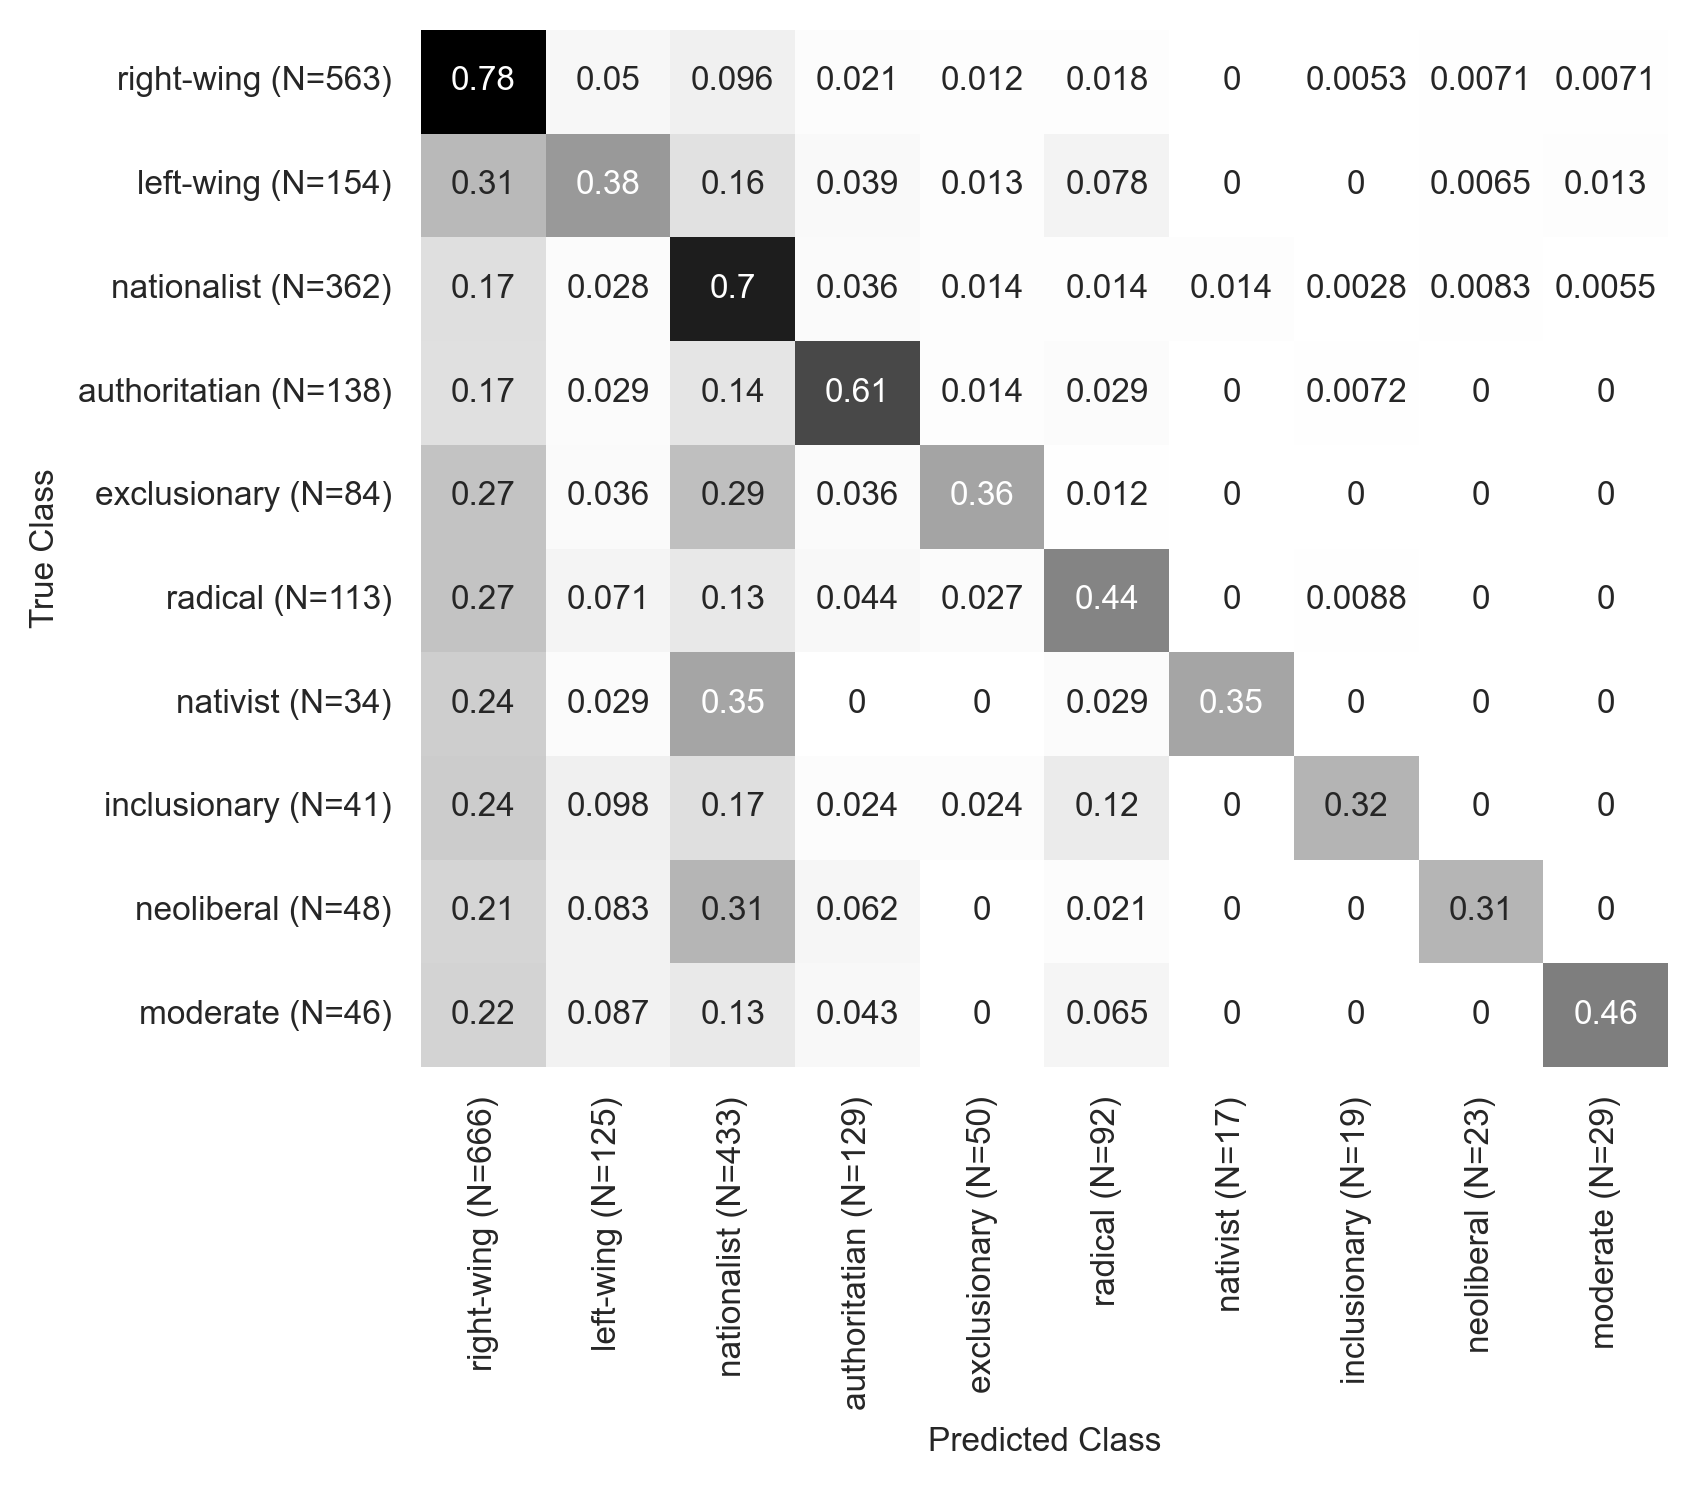

In [35]:
plt.style.use("fast")
plt.rcParams["font.family"] = "arial"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(freqs_df, annot=True, cbar=None, cmap="Greys", ax=ax)
#sns.heatmap(dataframe, annot=True, cbar=None, cmap="Greys", fmt='d', ax=ax)

ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

In [36]:
fig.savefig("../figures/confusion_matrix_LR.png")

# Matrix as network

In [37]:
labels_mapping = dict([(i,label) for i, label in enumerate(labels)])
classes_inxs = dict(zip(labels, range(len(labels))))
classes_inxs

{'right-wing': 0,
 'left-wing': 1,
 'nationalist': 2,
 'authoritatian': 3,
 'exclusionary': 4,
 'radical': 5,
 'nativist': 6,
 'inclusionary': 7,
 'neoliberal': 8,
 'moderate': 9}

In [38]:
labels_mapping

{0: 'right-wing',
 1: 'left-wing',
 2: 'nationalist',
 3: 'authoritatian',
 4: 'exclusionary',
 5: 'radical',
 6: 'nativist',
 7: 'inclusionary',
 8: 'neoliberal',
 9: 'moderate'}

In [39]:
matrix = confusion_matrix(y_test, y_predicted, labels=labels, normalize="true")
matrix

array([[0.78330373, 0.04973357, 0.09591474, 0.02131439, 0.01243339,
        0.01776199, 0.        , 0.0053286 , 0.0071048 , 0.0071048 ],
       [0.30519481, 0.38311688, 0.16233766, 0.03896104, 0.01298701,
        0.07792208, 0.        , 0.        , 0.00649351, 0.01298701],
       [0.17403315, 0.02762431, 0.70441989, 0.0359116 , 0.01381215,
        0.01381215, 0.01381215, 0.00276243, 0.00828729, 0.00552486],
       [0.16666667, 0.02898551, 0.14492754, 0.60869565, 0.01449275,
        0.02898551, 0.        , 0.00724638, 0.        , 0.        ],
       [0.27380952, 0.03571429, 0.28571429, 0.03571429, 0.35714286,
        0.01190476, 0.        , 0.        , 0.        , 0.        ],
       [0.27433628, 0.07079646, 0.13274336, 0.04424779, 0.02654867,
        0.44247788, 0.        , 0.00884956, 0.        , 0.        ],
       [0.23529412, 0.02941176, 0.35294118, 0.        , 0.        ,
        0.02941176, 0.35294118, 0.        , 0.        , 0.        ],
       [0.24390244, 0.09756098, 0.1707317

In [40]:
matrix.diagonal()

array([0.78330373, 0.38311688, 0.70441989, 0.60869565, 0.35714286,
       0.44247788, 0.35294118, 0.31707317, 0.3125    , 0.45652174])

In [41]:
import networkx as nx

In [42]:
M = nx.from_numpy_matrix(matrix, parallel_edges=True, create_using=nx.MultiDiGraph)

In [43]:
M.remove_edges_from(nx.selfloop_edges(M))
M.edges(data=True)

OutMultiEdgeDataView([(0, 1, {'weight': 0.0497335701598579}), (0, 2, {'weight': 0.09591474245115453}), (0, 3, {'weight': 0.021314387211367674}), (0, 4, {'weight': 0.012433392539964476}), (0, 5, {'weight': 0.017761989342806393}), (0, 7, {'weight': 0.0053285968028419185}), (0, 8, {'weight': 0.007104795737122558}), (0, 9, {'weight': 0.007104795737122558}), (1, 0, {'weight': 0.3051948051948052}), (1, 2, {'weight': 0.16233766233766234}), (1, 3, {'weight': 0.03896103896103896}), (1, 4, {'weight': 0.012987012987012988}), (1, 5, {'weight': 0.07792207792207792}), (1, 8, {'weight': 0.006493506493506494}), (1, 9, {'weight': 0.012987012987012988}), (2, 0, {'weight': 0.17403314917127072}), (2, 1, {'weight': 0.027624309392265192}), (2, 3, {'weight': 0.03591160220994475}), (2, 4, {'weight': 0.013812154696132596}), (2, 5, {'weight': 0.013812154696132596}), (2, 6, {'weight': 0.013812154696132596}), (2, 7, {'weight': 0.0027624309392265192}), (2, 8, {'weight': 0.008287292817679558}), (2, 9, {'weight': 0.

In [44]:
nodes_dict = dict([(i, {"correct" : val}) for i, val in enumerate(matrix.diagonal())])
nodes_dict

{0: {'correct': 0.783303730017762},
 1: {'correct': 0.38311688311688313},
 2: {'correct': 0.7044198895027625},
 3: {'correct': 0.6086956521739131},
 4: {'correct': 0.35714285714285715},
 5: {'correct': 0.4424778761061947},
 6: {'correct': 0.35294117647058826},
 7: {'correct': 0.3170731707317073},
 8: {'correct': 0.3125},
 9: {'correct': 0.45652173913043476}}

In [45]:
G = nx.Graph()
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 0
    if G.has_edge(u,v):
        G[u][v]['weight'] = (G[u][v]['weight'] + w) / 2
    else:
        G.add_edge(u, v, weight=w)
nx.set_node_attributes(G, nodes_dict)
G = nx.relabel_nodes(G, labels_mapping)

In [46]:
G.nodes(data=True)

NodeDataView({'right-wing': {'correct': 0.783303730017762}, 'left-wing': {'correct': 0.38311688311688313}, 'nationalist': {'correct': 0.7044198895027625}, 'authoritatian': {'correct': 0.6086956521739131}, 'exclusionary': {'correct': 0.35714285714285715}, 'radical': {'correct': 0.4424778761061947}, 'inclusionary': {'correct': 0.3170731707317073}, 'neoliberal': {'correct': 0.3125}, 'moderate': {'correct': 0.45652173913043476}, 'nativist': {'correct': 0.35294117647058826}})

In [47]:
nx.get_edge_attributes(G, "weight")

{('right-wing', 'left-wing'): 0.17746418767733155,
 ('right-wing', 'nationalist'): 0.13497394581121264,
 ('right-wing', 'authoritatian'): 0.09399052693901716,
 ('right-wing', 'exclusionary'): 0.14312145817474414,
 ('right-wing', 'radical'): 0.14604913626432353,
 ('right-wing', 'inclusionary'): 0.12461551791361608,
 ('right-wing', 'neoliberal'): 0.10771906453522795,
 ('right-wing', 'moderate'): 0.11224805004247432,
 ('right-wing', 'nativist'): 0.23529411764705882,
 ('left-wing', 'nationalist'): 0.09498098586496376,
 ('left-wing', 'authoritatian'): 0.03397327310370789,
 ('left-wing', 'exclusionary'): 0.024350649350649352,
 ('left-wing', 'radical'): 0.07435926904953453,
 ('left-wing', 'neoliberal'): 0.04491341991341991,
 ('left-wing', 'moderate'): 0.04997176736307171,
 ('left-wing', 'nativist'): 0.029411764705882353,
 ('left-wing', 'inclusionary'): 0.0975609756097561,
 ('nationalist', 'authoritatian'): 0.0904195692209144,
 ('nationalist', 'exclusionary'): 0.14976322020520916,
 ('nationali

In [48]:
pos = nx.circular_layout(G)
edge_sizes = [w *20 for w in nx.get_edge_attributes(G, "weight").values()]
edge_sizes
# generate the node positions

[3.549283753546631,
 2.699478916224253,
 1.8798105387803432,
 2.862429163494883,
 2.9209827252864704,
 2.492310358272322,
 2.154381290704559,
 2.2449610008494862,
 4.705882352941177,
 1.899619717299275,
 0.6794654620741578,
 0.487012987012987,
 1.4871853809906908,
 0.8982683982683982,
 0.9994353472614342,
 0.5882352941176471,
 1.951219512195122,
 1.8083913844182882,
 2.995264404104183,
 1.46555517527991,
 3.6675333116672086,
 1.734941382562997,
 3.2078729281767955,
 1.359596444871487,
 0.5020703933747412,
 0.7323329485699628,
 0.31636620714033226,
 1.25,
 0.8695652173913043,
 0.38453434471133585,
 0.4878048780487805,
 1.3080077703431903,
 0.5882352941176471,
 0.41666666666666663,
 1.3043478260869565]

In [49]:
color_vals = [val for val in list(nx.get_node_attributes(G, "correct").values())]
color_vals

[0.783303730017762,
 0.38311688311688313,
 0.7044198895027625,
 0.6086956521739131,
 0.35714285714285715,
 0.4424778761061947,
 0.3170731707317073,
 0.3125,
 0.45652173913043476,
 0.35294117647058826]

In [50]:
color_vals_labels = ["white" if n > 0.5 else "black" for n in color_vals]
color_vals_labels

['white',
 'black',
 'white',
 'white',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black']

In [51]:
pos

{'right-wing': array([1.0000000e+00, 1.4702742e-08]),
 'left-wing': array([0.809017  , 0.58778526]),
 'nationalist': array([0.30901698, 0.95105655]),
 'authoritatian': array([-0.30901702,  0.95105649]),
 'exclusionary': array([-0.80901699,  0.58778526]),
 'radical': array([-9.99999988e-01, -7.27200340e-08]),
 'inclusionary': array([-0.80901693, -0.58778529]),
 'neoliberal': array([-0.30901711, -0.95105646]),
 'moderate': array([ 0.30901713, -0.95105646]),
 'nativist': array([ 0.80901694, -0.58778529])}

In [52]:
for pos_tup, color in zip(pos.items(), color_vals_labels):
    (pos_tup[1][0], pos_tup[1][1], pos_tup[0]) #, font_size=6, c=color)

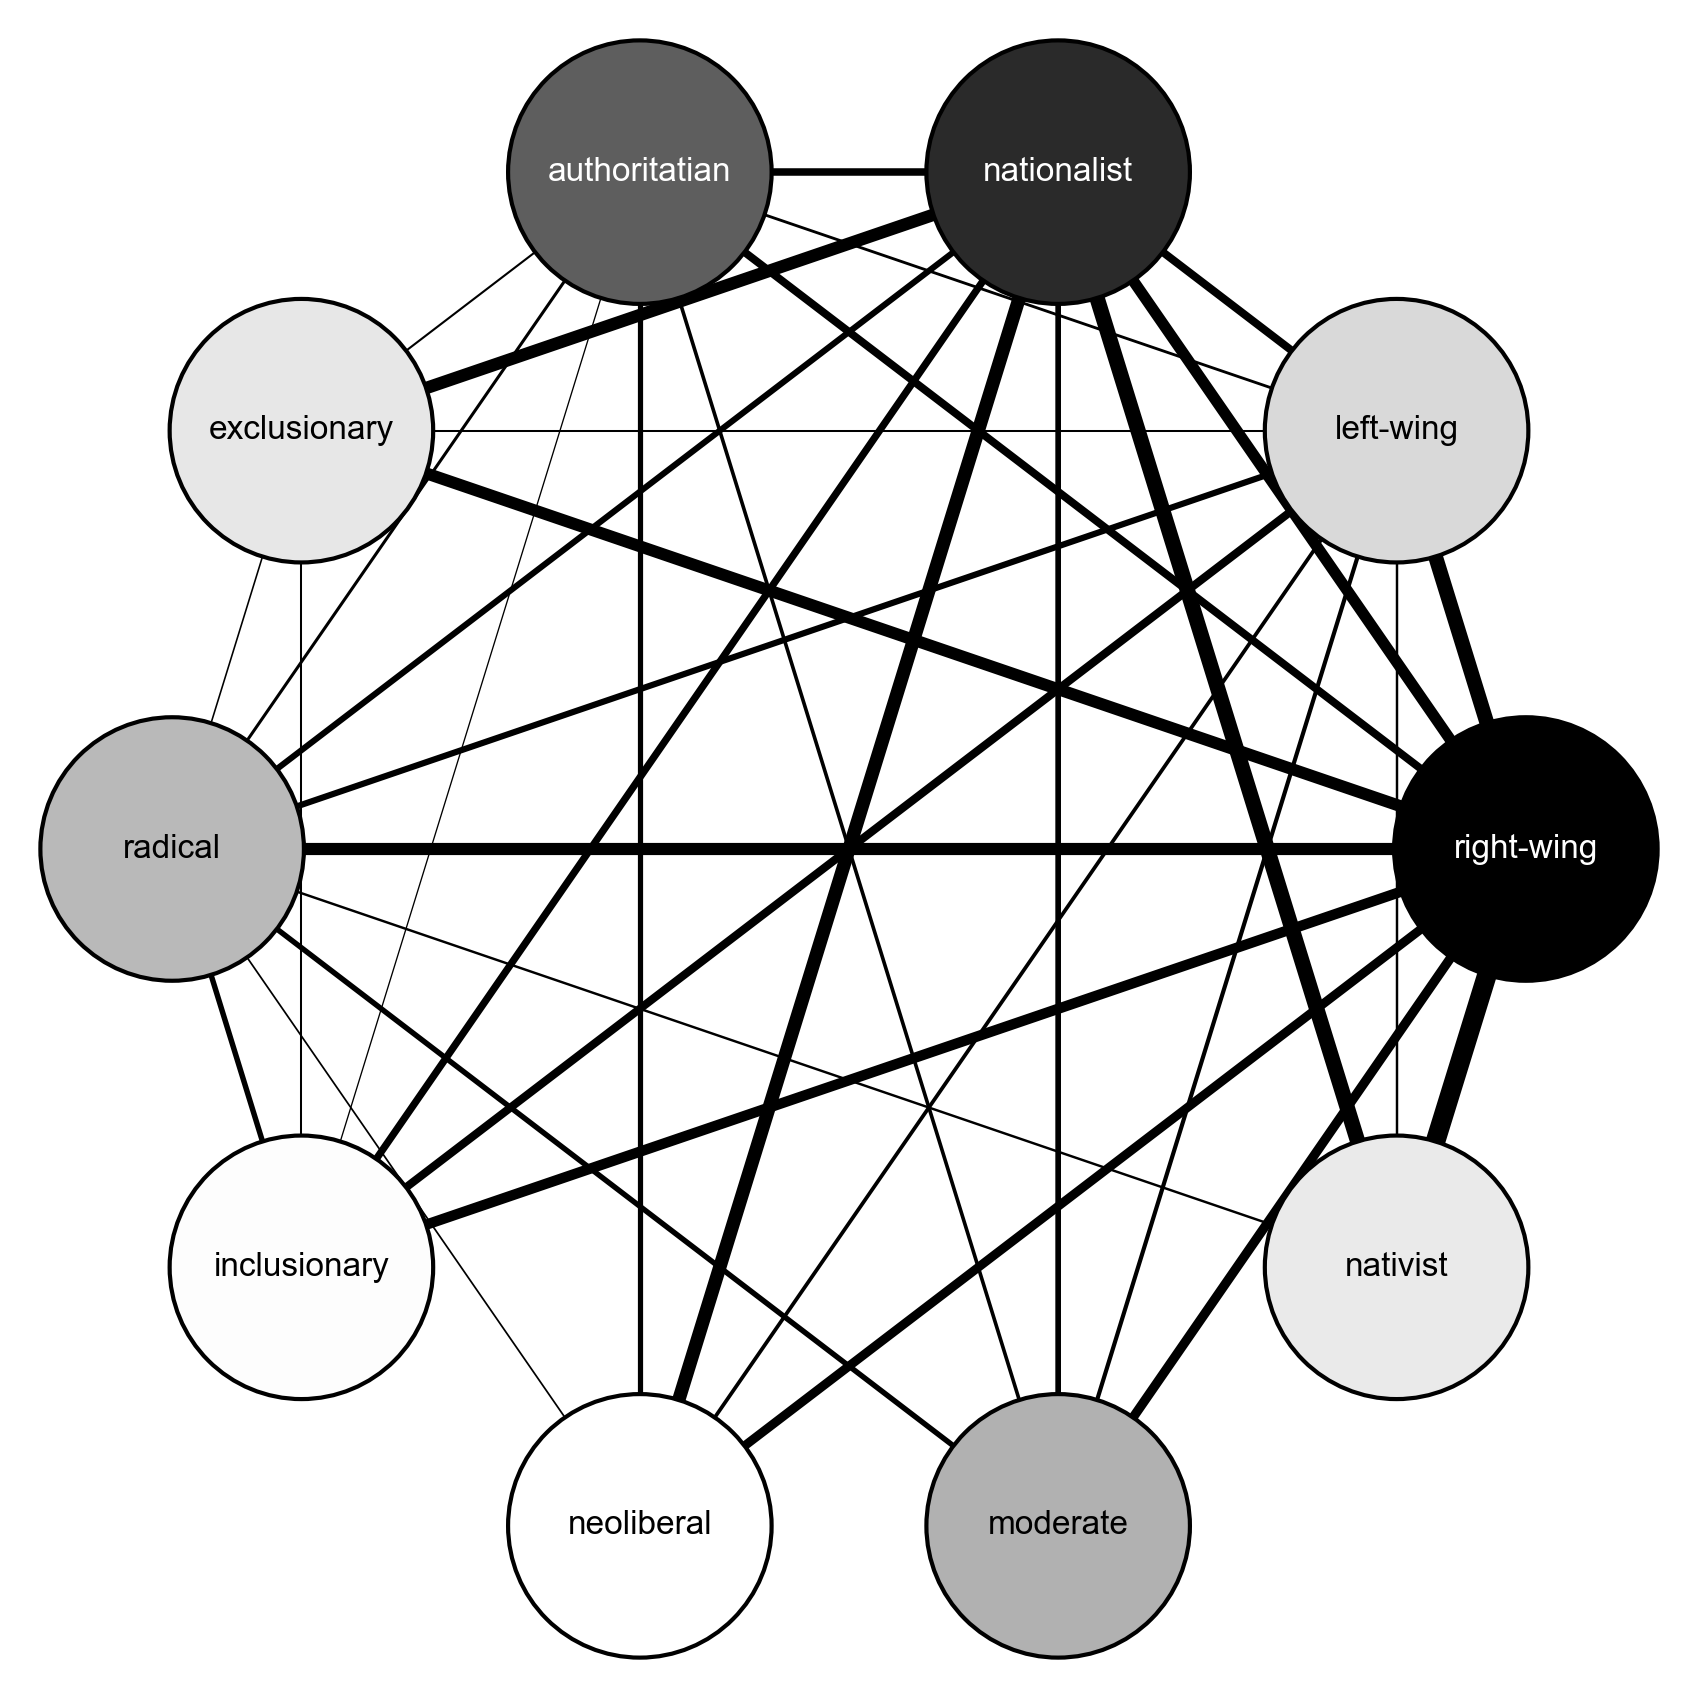

In [53]:
  #, font_size=6, c=color)
fig, ax = plt.subplots(figsize=(5.7, 5.7), dpi=300, tight_layout=True)

nx.draw_networkx_nodes(G, pos, node_size=4000, node_color=color_vals, edgecolors="black", cmap=plt.cm.binary, ax=ax)
nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax)
for pos_tup, color in zip(pos.items(), color_vals_labels):
    ax.text(pos_tup[1][0], pos_tup[1][1], pos_tup[0], size=8, c=color, horizontalalignment='center', verticalalignment='center')

ax.set_axis_off()

In [54]:
fig.savefig("../figures/circular_network.png")

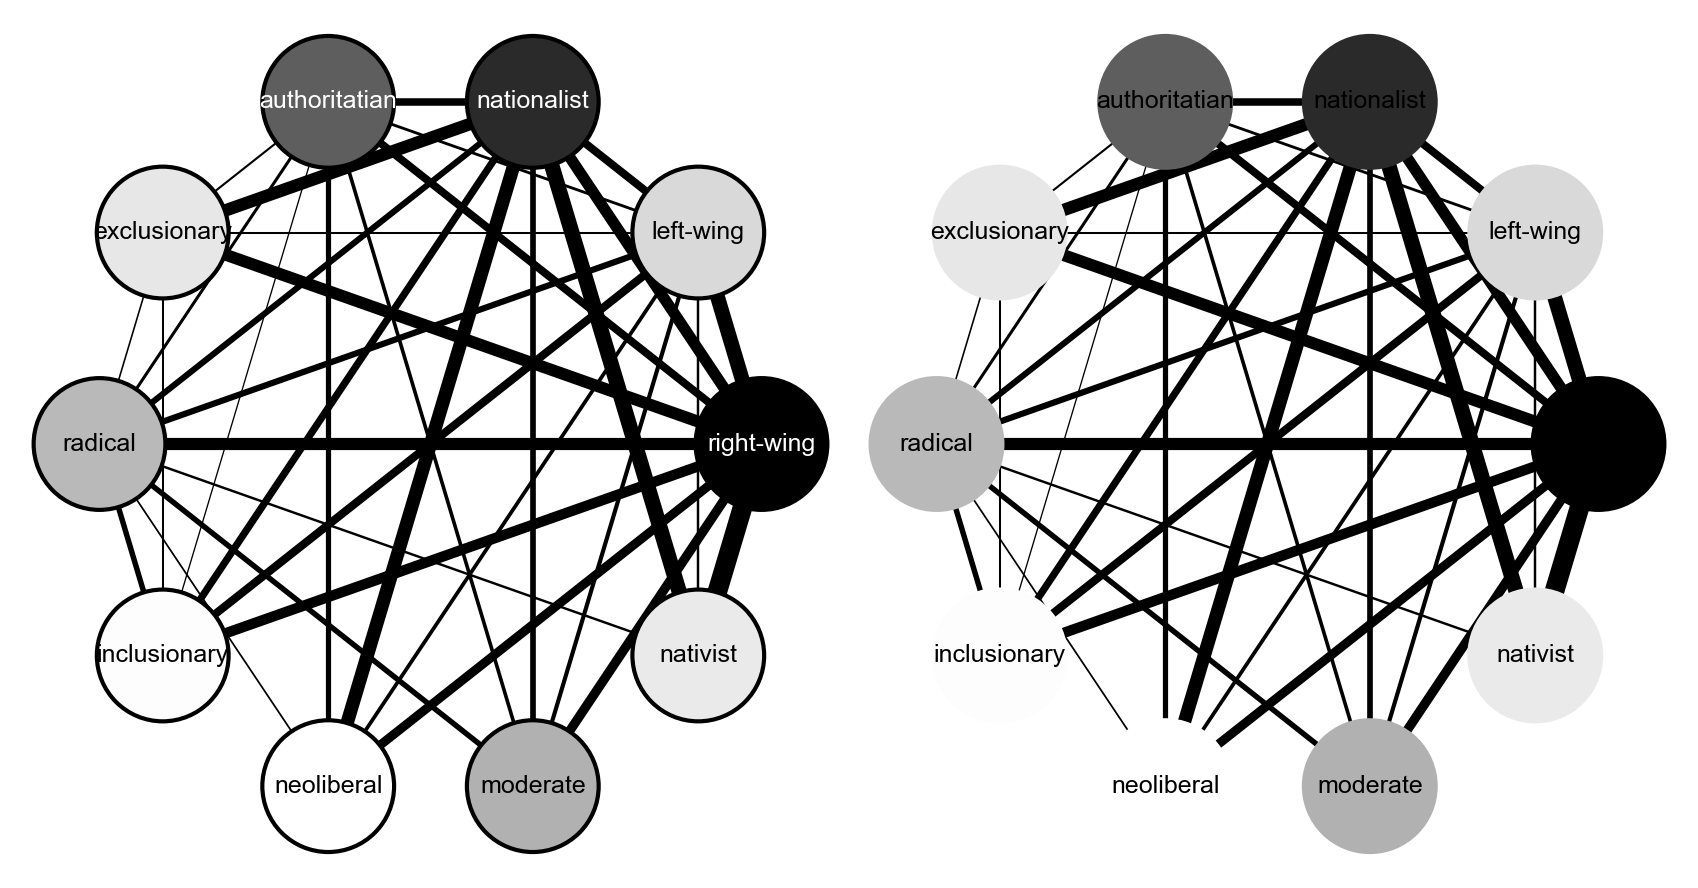

In [55]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(5.7,3), dpi=300, tight_layout=True)

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=color_vals, edgecolors="black",cmap=plt.cm.binary, ax=ax1)
nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax1)
for pos_tup, color in zip(pos.items(), color_vals_labels):
    ax1.text(pos_tup[1][0], pos_tup[1][1], pos_tup[0], size=6, c=color, horizontalalignment='center', verticalalignment='center')

ax1.set_axis_off()

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=color_vals, cmap=plt.cm.binary, ax=ax2)
nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax2)
nx.draw_networkx_labels(G, pos=pos, font_size=6, ax=ax2)

ax2.set_axis_off()

In [56]:
    # filter test data by year
for year in range(2011,2021):
        filtered_indeces = [i for i, y in enumerate(years_test) if int(y) == year]
        y_test_filtered = np.array(y_test)[filtered_indeces]
        X_test_filtered = X_test[filtered_indeces, :]
        y_predicted_filtered = classifier.predict(X_test_filtered)
        print(year, f1_score(y_predicted_filtered, y_test_filtered, average="weighted"))

2011 0.7753667953667953
2012 0.5846930846930847
2013 0.7358717910442047
2014 0.6509430758467986
2015 0.5386551496748865
2016 0.6191838786730475
2017 0.5338518256953233
2018 0.6269536782704286
2019 0.6132166896157883
2020 0.678292511178697


In [57]:
test_classes_reality = dict([(poptype, list(y_test_filtered).count(poptype)) for poptype in poptypes])
test_classes_reality

labels_reality = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_reality.items()]
labels_reality


['right-wing (N=132)',
 'left-wing (N=29)',
 'nationalist (N=116)',
 'authoritatian (N=46)',
 'exclusionary (N=13)',
 'radical (N=18)',
 'nativist (N=3)',
 'inclusionary (N=4)',
 'neoliberal (N=9)',
 'moderate (N=7)']

In [61]:
def from_indeces_to_matrix(indices):
    y_test_filtered = np.array(y_test)[indices]
    X_test_filtered = X_test[indices, :]
    y_predicted_filtered = classifier.predict(X_test_filtered)
    test_classes_reality = dict([(poptype, list(y_test_filtered).count(poptype)) for poptype in poptypes])
    labels_reality = [t[0] + " (N={})".format(str(t[1])) for t in test_classes_reality.items()]
    matrix = confusion_matrix(y_test_filtered, y_predicted_filtered, labels=labels) #, normalize="true")
    dataframe = pd.DataFrame(matrix, columns=labels, index=labels_reality)
    totals = []
    for i in range(len(dataframe)):
        totals.append(dataframe.iloc[i].sum())
    freqs_dict = {}
    for col in dataframe.columns:
        freqs_dict[col] = dataframe[col] / totals
    freqs_df = pd.DataFrame(freqs_dict)
    return freqs_df

In [67]:
filtered_indeces = [i for i, y in enumerate(years_test) if int(y) < 2016]
freqs_df1 = from_indeces_to_matrix(filtered_indeces)

y_test_filtered = np.array(y_test)[filtered_indeces]
X_test_filtered = X_test[filtered_indeces, :]
y_predicted_filtered = classifier.predict(X_test_filtered)
np.round(f1_score(y_predicted_filtered, y_test_filtered, average="weighted"), 2)

0.67

In [69]:
np.round(accuracy_score(y_predicted_filtered, y_test_filtered), 2)

0.66

In [66]:
filtered_indeces = [i for i, y in enumerate(years_test) if int(y) >= 2016]
freqs_df2 = from_indeces_to_matrix(filtered_indeces)

y_test_filtered = np.array(y_test)[filtered_indeces]
X_test_filtered = X_test[filtered_indeces, :]
y_predicted_filtered = classifier.predict(X_test_filtered)
np.round(f1_score(y_predicted_filtered, y_test_filtered, average="weighted"), 2)

0.62

Text(0.5, 42.059895833333385, 'Predicted Class')

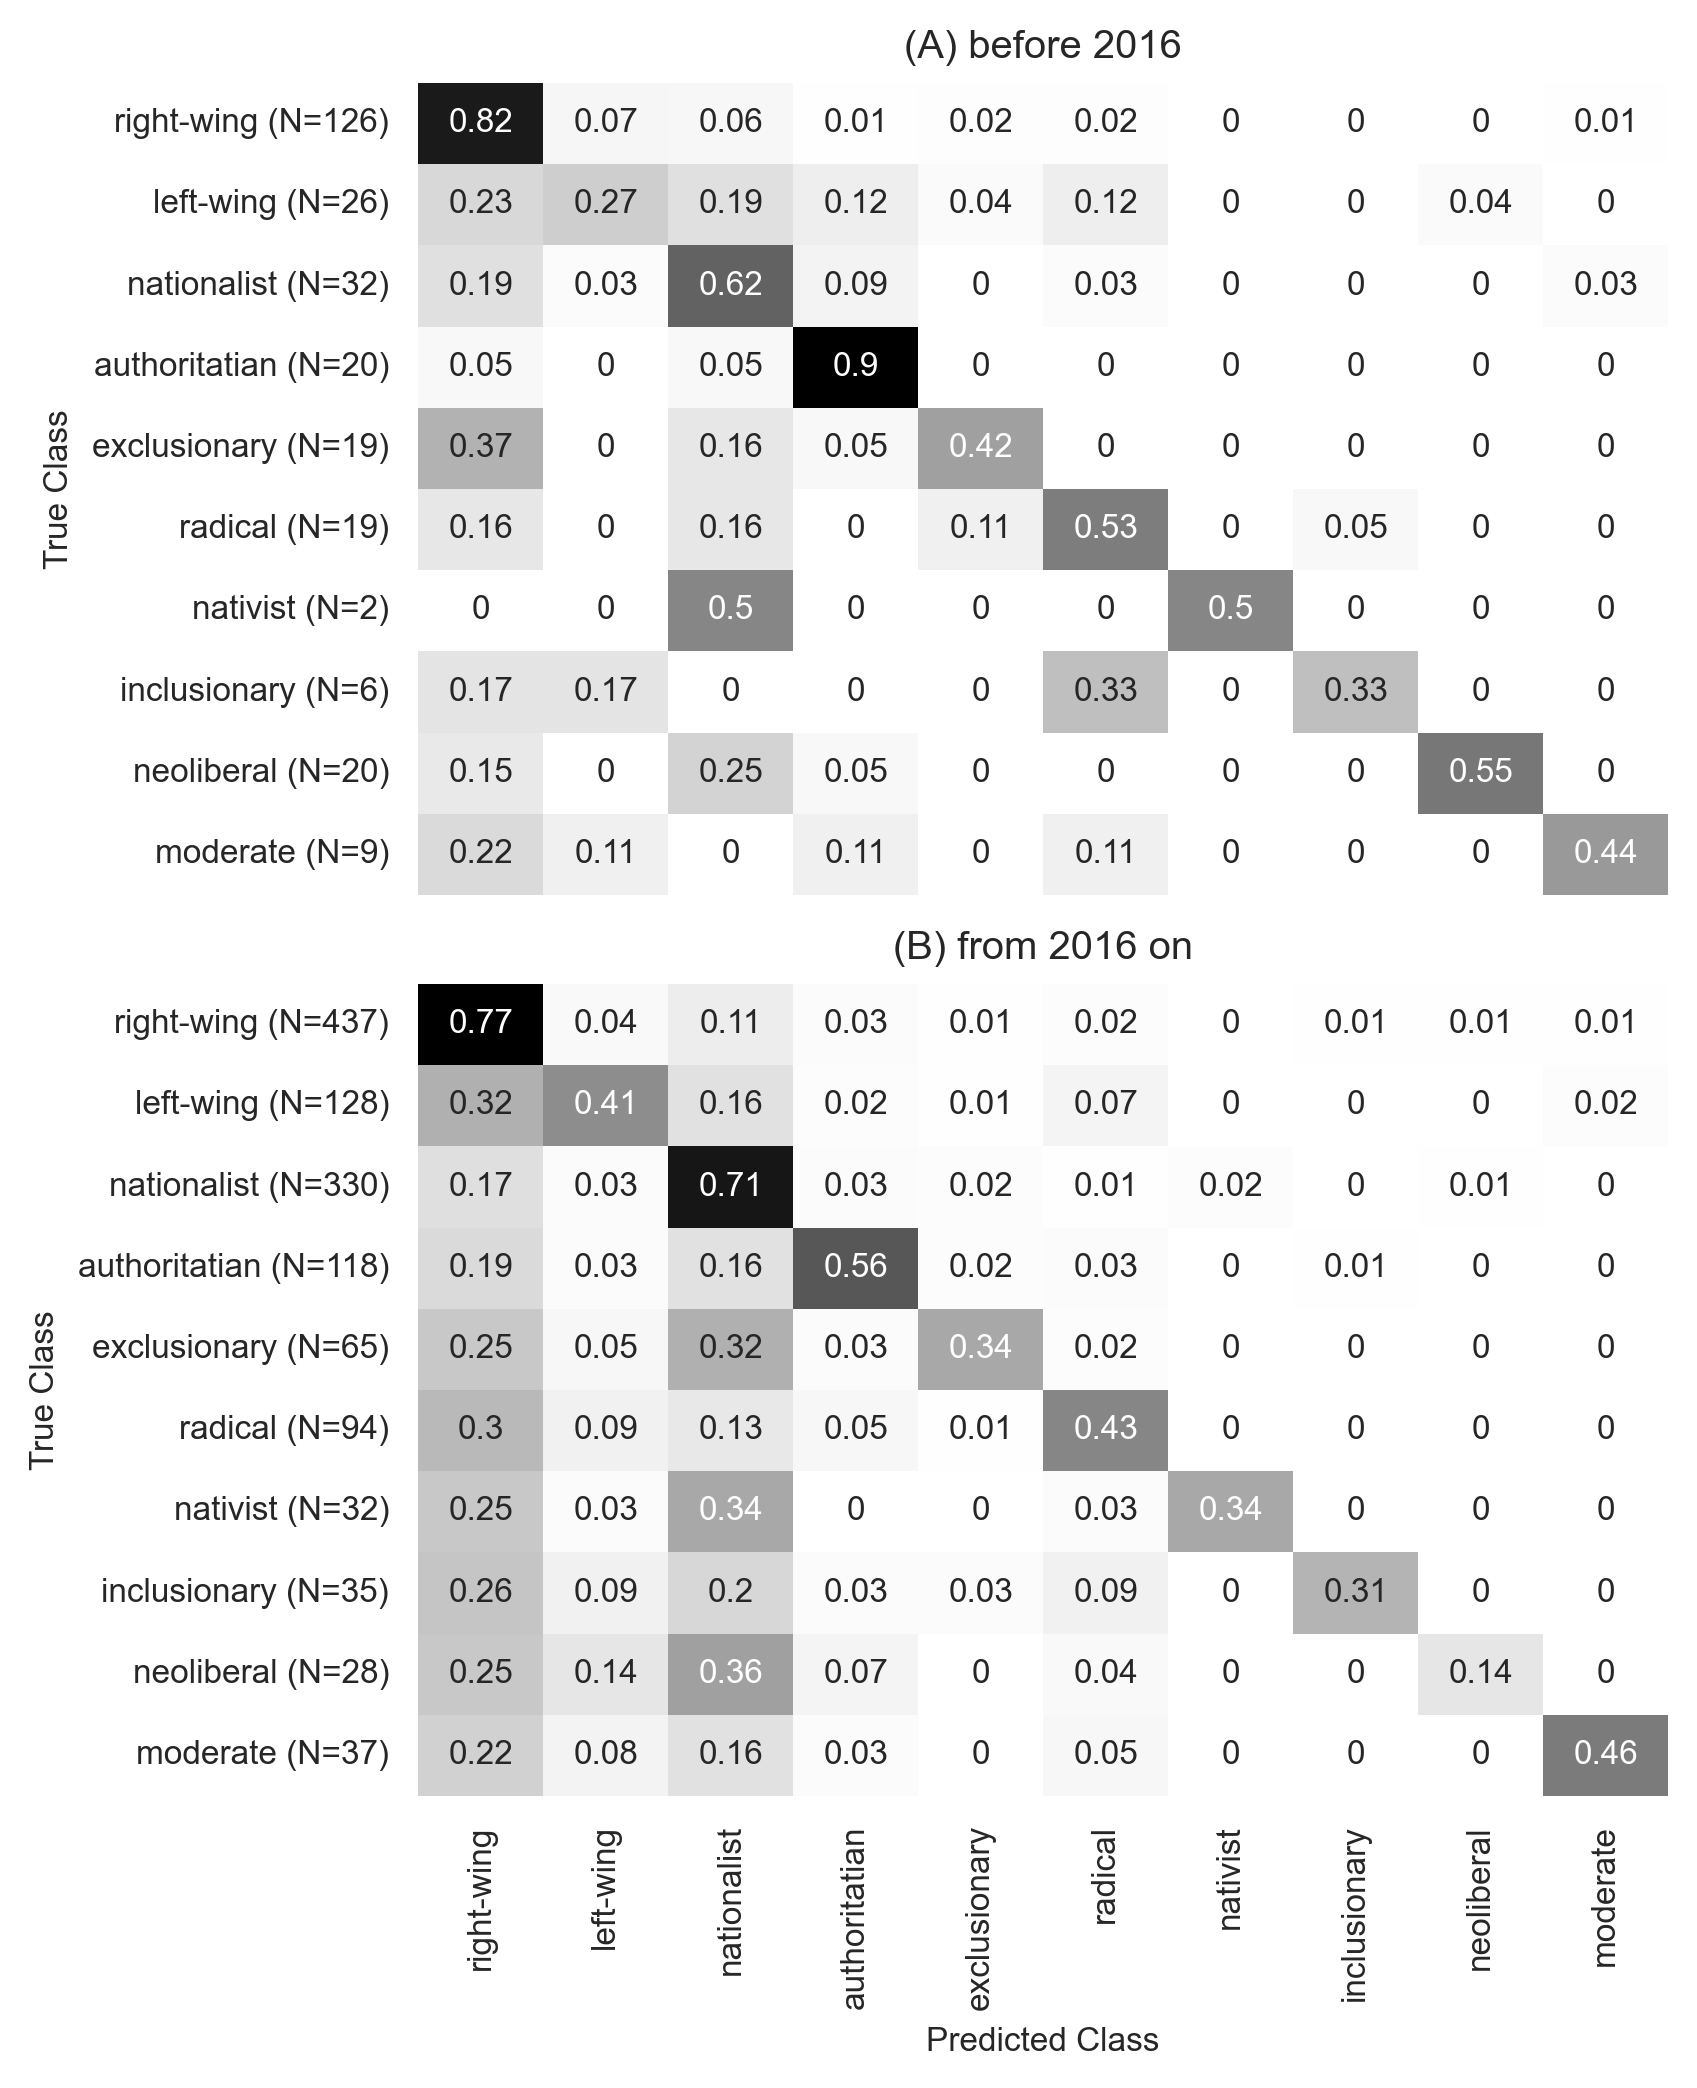

In [59]:

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5.7, 7), dpi=300, tight_layout=True)

sns.heatmap(freqs_df1.round(2), annot=True, cbar=None, edgecolor="black", cmap="Greys", ax=ax1)
sns.heatmap(freqs_df2.round(2), annot=True, cbar=None, edgecolor="black", cmap="Greys", ax=ax2)

ax1.set_title("(A) before 2016")
ax1.set_ylabel("True Class")
ax1.set_xticklabels([])

ax2.set_title("(B) from 2016 on")

ax2.set_ylabel("True Class")
ax2.set_xlabel("Predicted Class")


In [60]:
fig.savefig("../figures/confusion_matrix_before-vs-after2016.png")

# NN based classification

## Simply neural network

In [61]:
# requires to be connected to a properly configured python environment with tensorflow etc.
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import models
from keras import layers
from keras.layers import Embedding

In [62]:
classes

['right-wing',
 'left-wing',
 'nationalist',
 'authoritatian',
 'exclusionary',
 'radical',
 'nativist',
 'inclusionary',
 'neoliberal',
 'moderate']

In [63]:
classes_inxs = dict(zip(classes, range(len(classes))))

In [64]:
classes_inxs

{'right-wing': 0,
 'left-wing': 1,
 'nationalist': 2,
 'authoritatian': 3,
 'exclusionary': 4,
 'radical': 5,
 'nativist': 6,
 'inclusionary': 7,
 'neoliberal': 8,
 'moderate': 9}

In [65]:
def to_one_hot(y, classes):
    classes_inxs_dict = dict(zip(classes, range(len(classes))))
    results = np.zeros((len(y), len(classes)))
    for i, label in enumerate(y):
        results[i, classes_inxs_dict[label]] = 1.
    return results, classes_inxs_dict

one_hot_labels, classes_inxs_dict = to_one_hot(y, classes)

In [66]:
inxs_classes_dict = dict([(t[1], t[0]) for t in classes_inxs_dict.items()])
inxs_classes_dict

{0: 'right-wing',
 1: 'left-wing',
 2: 'nationalist',
 3: 'authoritatian',
 4: 'exclusionary',
 5: 'radical',
 6: 'nativist',
 7: 'inclusionary',
 8: 'neoliberal',
 9: 'moderate'}

In [67]:
one_hot_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [68]:
# TRAIN vs TEST

x_train_full, x_test, y_train_full, y_test_one_hot, years_train_full, years_test = train_test_split(X, one_hot_labels, years, test_size=0.2, random_state=1)

# actual TRAIN vs. internal VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=1)

In [69]:
len(years_test)

1583

In [70]:
# since our classes are highly unbalanced w1 weighted is perhaps the best metric for model performance
def f1_weighted(y_true, y_pred):
    y_true = np.ndarray.argmax(y_true.numpy(), axis=1)
    y_pred = np.ndarray.argmax(y_pred.numpy(), axis=1)
    return f1_score(y_true, y_pred, average="weighted")

In [71]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(len(x_train[0]),)))
model.add(layers.Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[f1_weighted])

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(x_val, y_val))

2023-03-07 11:16:28.276065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 11:16:28.276692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-03-07 11:16:29.012238: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40/40 [==============================] - ETA: 0s - loss: 1.9462 - f1_weighted: 0.2367

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


40/40 [==============================] - 8s 109ms/step - loss: 1.9462 - f1_weighted: 0.2367 - val_loss: 1.6946 - val_f1_weighted: 0.3288
Epoch 2/10
40/40 [==============================] - 4s 101ms/step - loss: 1.4030 - f1_weighted: 0.4349 - val_loss: 1.4446 - val_f1_weighted: 0.4245
Epoch 3/10
40/40 [==============================] - 4s 88ms/step - loss: 0.8860 - f1_weighted: 0.6973 - val_loss: 1.2758 - val_f1_weighted: 0.5594
Epoch 4/10
40/40 [==============================] - 4s 98ms/step - loss: 0.4560 - f1_weighted: 0.8945 - val_loss: 1.2266 - val_f1_weighted: 0.6000
Epoch 5/10
40/40 [==============================] - 3s 86ms/step - loss: 0.2155 - f1_weighted: 0.9727 - val_loss: 1.2560 - val_f1_weighted: 0.6096
Epoch 6/10
40/40 [==============================] - 3s 80ms/step - loss: 0.1078 - f1_weighted: 0.9941 - val_loss: 1.2908 - val_f1_weighted: 0.6150
Epoch 7/10
40/40 [==============================] - 4s 88ms/step - loss: 0.0602 - f1_weighted: 0.9994 - val_loss: 1.3462 - val_

In [72]:
results = model.evaluate(x_test, y_test_one_hot)
results

 1/50 [..............................] - ETA: 7s - loss: 1.5837 - f1_weighted: 0.6347

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 [==============================] - 3s 52ms/step - loss: 1.4935 - f1_weighted: 0.5811


[1.493465542793274, 0.5811036825180054]

In [73]:
y_predicted_one_hot = model.predict(x_test)
y_predicted = [inxs_classes_dict[i] for i in np.argmax(y_predicted_one_hot, axis=1)]

19/50 [==========>...................] - ETA: 0s

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 [==============================] - 0s 5ms/step


In [74]:
f1_score(y_predicted, y_test, average="weighted")

0.25287863484275663

In [75]:
inxs_classes_dict

{0: 'right-wing',
 1: 'left-wing',
 2: 'nationalist',
 3: 'authoritatian',
 4: 'exclusionary',
 5: 'radical',
 6: 'nativist',
 7: 'inclusionary',
 8: 'neoliberal',
 9: 'moderate'}

In [76]:
pd.DataFrame(y_predicted_one_hot[:10].round(2), columns=labels)

,right-wing,left-wing,nationalist,authoritatian,exclusionary,radical,nativist,inclusionary,neoliberal,moderate
0,0.98,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.11,0.17,0.53,0.04,0.01,0.01,0.00,0.02,0.02,0.09
2,0.00,0.00,0.01,0.98,0.00,0.00,0.00,0.00,0.00,0.00
3,0.79,0.11,0.03,0.02,0.02,0.01,0.00,0.00,0.01,0.00
4,0.59,0.00,0.24,0.02,0.02,0.01,0.02,0.09,0.00,0.00
5,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.89,0.06,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.00
7,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.05,0.00,0.00,0.91,0.00,0.01,0.01,0.00,0.00,0.00


In [77]:
len(np.max(y_predicted_one_hot, axis=1))

1583

In [78]:
sum(np.max(y_predicted_one_hot, axis=1) > 0.75)

993

# Neural networks with embeddings

In [15]:
vocab = [tup[0] for tup in vocab_counts]

In [16]:
w2v = KeyedVectors.load("../data/large_data/w2v_news300.model")
w2v.most_similar("extremism")

[('religious_extremism', 0.8095038533210754),
 ('radicalism', 0.7823387980461121),
 ('violent_extremism', 0.7761071920394897),
 ('Islamic_extremism', 0.7622053027153015),
 ('Islamic_fundamentalism', 0.7453163266181946),
 ('Islamic_radicalism', 0.7362303137779236),
 ('militancy', 0.7344785928726196),
 ('radical_Islam', 0.7271879315376282),
 ('Islamist_extremism', 0.7208510041236877),
 ('extremists', 0.7103613615036011)]

In [17]:
w2v_filtered = KeyedVectors(vector_size=300)
vocab_filtered = []
# Iterate over the original KeyedVectors object
for word in vocab:
    try:
        w2v_filtered[word] = w2v[word]
        vocab_filtered.append(word)
    except:
        pass

In [19]:
w2v_filtered.vectors[0]

array([ 3.78906250e-01,  5.02929688e-02, -3.19824219e-02,  4.02343750e-01,
       -8.93554688e-02, -1.26953125e-01,  3.07617188e-02,  1.50390625e-01,
        6.88476562e-02, -1.47460938e-01, -6.68945312e-02, -9.86328125e-02,
        9.61914062e-02,  4.45312500e-01, -2.85644531e-02,  5.34667969e-02,
       -1.27563477e-02,  3.41796875e-01,  1.18652344e-01, -1.09863281e-01,
        2.12890625e-01,  2.34375000e-01,  2.63671875e-01,  2.27539062e-01,
        5.24902344e-02, -1.16210938e-01, -9.47265625e-02, -1.27929688e-01,
        5.00000000e-01,  2.00195312e-01, -1.87500000e-01,  1.78710938e-01,
        5.03540039e-03,  1.04492188e-01,  2.73437500e-01, -1.90429688e-01,
        5.46875000e-02, -1.74804688e-01,  3.90625000e-02,  6.49414062e-02,
        3.57421875e-01, -2.37304688e-01,  3.94531250e-01, -2.31933594e-02,
       -1.24023438e-01, -4.12597656e-02, -7.56835938e-02,  5.63964844e-02,
        4.62890625e-01, -1.08398438e-01, -1.06933594e-01, -4.58984375e-02,
       -6.83593750e-02, -

In [134]:
max([len(conc) for conc in concs])

20

In [135]:
vectorizer = TextVectorization(
    standardize=None,
    output_mode="int",
    output_sequence_length=20
    #vocabulary=vocab
)

In [136]:
vectorizer.adapt([" ".join(conc) for conc in concs])

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [137]:
#  index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
vectorizer([["be stupid populist"]])

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[2967,    1,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [138]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [139]:
voc[:5]

['', '[UNK]', 'populist', 'populism', 'party']

In [140]:
num_tokens = len(voc) + 2
embedding_dim = w2v_filtered.vectors.shape[1]
embedding_matrix = np.zeros((num_tokens, 300))
for word, i in word_index.items():
    try:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = vector = w2v[word]
    except:
        pass

In [141]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [142]:
sequences = vectorizer([" ".join(conc) for conc in concs]).numpy()
sequences[:20]

array([[ 1694,    37,   919,  1055,    56,  1350,   573,     5,   870,
            2,   194,   133,   678,  7081,  5006,   645,   426,    72,
          517, 10304],
       [ 6596,  1309,  4712,  1584,  1048,    36,  5448,   538,   118,
           12,     2,   582,  3968,    94,   142,  1370,     7,  4504,
          956,    84],
       [  118,  1305,     3,   167,   389,   236,   745,   102,   157,
         1654,     2,    10,   687,  2607,  2592,  3722,  6241,  8597,
          517,    12],
       [ 1140,   492,   913,   261,  6663,   499,  2319,  2757,  1133,
           91,     2,  1140,  6493,    21,    84,   461,  1447,   664,
          206,    27],
       [ 2227,   727,  4166,   203,    75,  1599,  2985,  1874,    63,
          103,     2,    10,  1778,     9,   195,  2009,   175,  2027,
           25,  2951],
       [    9,   195,  2009,   175,  2027,    25,  2951,   206,  1151,
            2,  2607,   687,     7,  2339,    49,   637,  2574,     2,
         8382,     7],
       [  

In [163]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(512, 5, activation="relu")(embedded_sequences)
#x = layers.MaxPooling1D(5)(x)
#x = layers.Conv1D(128, 5, activation="relu")(x)
#x = layers.MaxPooling1D(5)(x)
#x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(classes), activation='softmax')(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         4042200   
                                                                 
 conv1d_25 (Conv1D)          (None, None, 512)         768512    
                                                                 
 global_max_pooling1d_16 (Gl  (None, 512)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                          

In [164]:
# TRAIN vs TEST

x_train_full, x_test, y_train_full, y_test_one_hot = train_test_split(sequences, one_hot_labels, test_size=0.2, random_state=1)

# actual TRAIN vs. internal VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=1)

In [165]:
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=[f1_weighted]
)
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


74/74 [==============================] - ETA: 0s - loss: 1.9040 - f1_weighted: 0.2481

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


74/74 [==============================] - 7s 93ms/step - loss: 1.9040 - f1_weighted: 0.2481 - val_loss: 1.7933 - val_f1_weighted: 0.2177
Epoch 2/10
74/74 [==============================] - 7s 91ms/step - loss: 1.6145 - f1_weighted: 0.3801 - val_loss: 1.5688 - val_f1_weighted: 0.4101
Epoch 3/10
74/74 [==============================] - 7s 89ms/step - loss: 1.0555 - f1_weighted: 0.5993 - val_loss: 1.4712 - val_f1_weighted: 0.4837
Epoch 4/10
74/74 [==============================] - 7s 89ms/step - loss: 0.5099 - f1_weighted: 0.8199 - val_loss: 1.5990 - val_f1_weighted: 0.5279
Epoch 5/10
74/74 [==============================] - 6s 87ms/step - loss: 0.2150 - f1_weighted: 0.9384 - val_loss: 2.0242 - val_f1_weighted: 0.4941
Epoch 6/10
74/74 [==============================] - 6s 88ms/step - loss: 0.0868 - f1_weighted: 0.9815 - val_loss: 1.7980 - val_f1_weighted: 0.5629
Epoch 7/10
74/74 [==============================] - 6s 85ms/step - loss: 0.0494 - f1_weighted: 0.9906 - val_loss: 1.9888 - val_f1

In [166]:
results = model.evaluate(x_test, y_test_one_hot)
results

 2/47 [>.............................] - ETA: 2s - loss: 1.4146 - f1_weighted: 0.6781

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 3s 57ms/step - loss: 2.0383 - f1_weighted: 0.5782


[2.0383424758911133, 0.5782015919685364]

In [167]:
y_predicted_one_hot = model.predict(x_test)
y_predicted = [inxs_classes_dict[i] for i in np.argmax(y_predicted_one_hot, axis=1)]

f1_score(y_predicted, y_test, average="weighted")

24/47 [==============>...............] - ETA: 0s

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


47/47 [==============================] - 0s 7ms/step


0.6250736879356592